In [186]:
import pandas as pd
import numpy as np
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from sklearn.model_selection import train_test_split
import joblib
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest, f_classif

In [187]:
x_train = pd.read_csv("data/processed/x_train.csv")
x_test  = pd.read_csv("data/processed/x_test.csv")
y_train = pd.read_csv("data/processed/y_train.csv").values.ravel()
y_test  = pd.read_csv("data/processed/y_test.csv").values.ravel()

In [188]:
rf = joblib.load("models/rf.pkl")
lr = joblib.load("models/lr.pkl")

In [189]:
def find_best_threshold_macro(model, x, y):
    y_proba = model.predict_proba(x)[:, 1]
    thresholds = np.linspace(0.1, 0.9, 81)
    f1_scores = [f1_score(y, (y_proba >= t).astype(int), average='macro') for t in thresholds]
    best_idx = np.argmax(f1_scores)
    return thresholds[best_idx], y_proba

In [190]:
def evaluate_model(model, x, y, name):
    best_thresh, y_proba = find_best_threshold_macro(model, x, y)
    y_pred = (y_proba >= best_thresh).astype(int)
    
    return {
        "Modelo": name,
        "Acurácia": accuracy_score(y, y_pred),
        "Precisão": precision_score(y, y_pred, pos_label=0),
        "Recall": recall_score(y, y_pred, pos_label=0),
        "F1": f1_score(y, y_pred, pos_label=0),
        "Predições": y_pred
    }

In [191]:
rf_train_metrics = evaluate_model(rf, x_train, y_train, "Random Forest (Treino)")
rf_test_metrics  = evaluate_model(rf, x_test, y_test, "Random Forest (Teste)")

lr_train_metrics = evaluate_model(lr, x_train, y_train, "Logistic Regression (Treino)")
lr_test_metrics  = evaluate_model(lr, x_test, y_test, "Logistic Regression (Teste)")

In [192]:
results_df = pd.DataFrame([
    rf_train_metrics, rf_test_metrics,
    lr_train_metrics, lr_test_metrics
])

In [193]:
results_df_display = results_df[["Modelo", "Acurácia", "Precisão", "Recall", "F1"]]
print("\n=== Comparação Final - Treino vs Teste ===")
print(results_df_display.to_string(index=False))



=== Comparação Final - Treino vs Teste ===
                      Modelo  Acurácia  Precisão   Recall       F1
      Random Forest (Treino)  0.910892  0.951775 0.932249 0.941911
       Random Forest (Teste)  0.787852  0.852961 0.877471 0.865042
Logistic Regression (Treino)  0.783265  0.867014 0.850822 0.858842
 Logistic Regression (Teste)  0.780371  0.864903 0.849195 0.856977


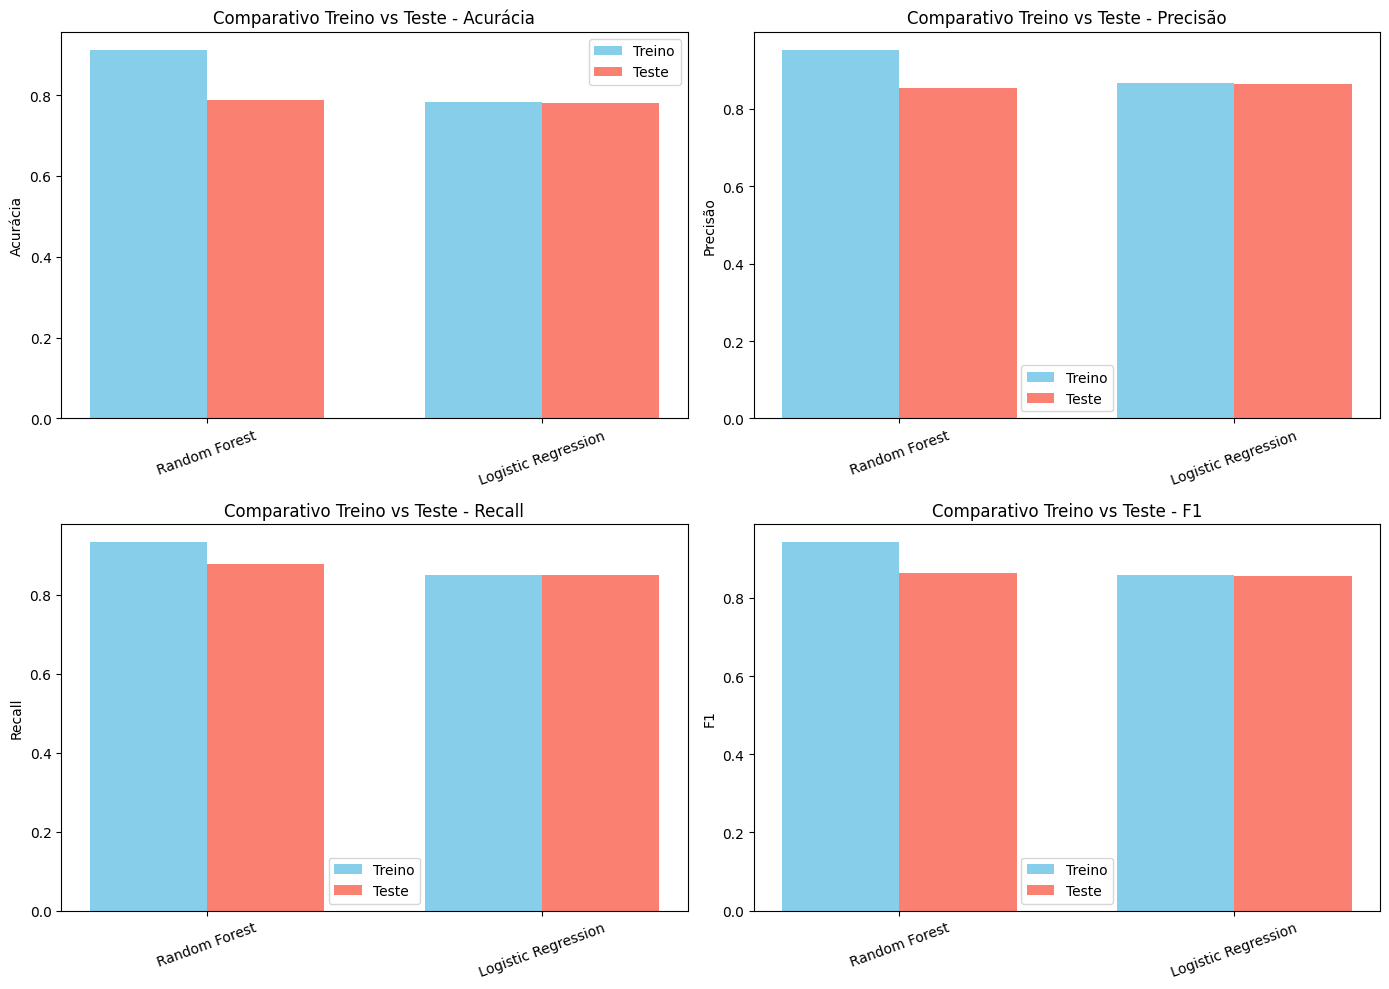

In [194]:
# Visualização gráfica
metrics = ["Acurácia", "Precisão", "Recall", "F1"]
model_names = ["Random Forest", "Logistic Regression"]

fig, axes = plt.subplots(2, 2, figsize=(14,10))
axes = axes.flatten()

for i, metric in enumerate(metrics):
    train_values = [rf_train_metrics[metric], lr_train_metrics[metric]]
    test_values  = [rf_test_metrics[metric], lr_test_metrics[metric]]
    
    x_pos = np.arange(len(model_names))
    width = 0.35
    
    axes[i].bar(x_pos - width/2, train_values, width, label='Treino', color='skyblue')
    axes[i].bar(x_pos + width/2, test_values, width, label='Teste', color='salmon')
    
    axes[i].set_xticks(x_pos)
    axes[i].set_xticklabels(model_names, rotation=20)
    axes[i].set_ylabel(metric)
    axes[i].set_title(f'Comparativo Treino vs Teste - {metric}')
    axes[i].legend()

plt.tight_layout()
plt.show()